In [1]:
# Imports
%load_ext autoreload
%autoreload 2

from os.path import exists
from pathlib import Path

import math

import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn # Includes all modules, nn.Linear, nn.Conv2d, BatchNorm etc
import torch.optim as optim # Is used for otimization algorithms such as Adam, SGD ...
from torch.utils.data import DataLoader # Helps with managing datasets in mini batches
from torch.utils.data import Dataset

import torchvision
import torchvision.datasets as datasets # Has standard datasets
import torchvision.transforms as transforms # Transformations to be used on images
import torchvision.transforms as T
import torchvision.transforms.functional as F
from torchvision.models import vgg19

from itertools import chain
from PIL import Image

from model import Generator, Discriminator # Models
from loss import VGGContentLoss
from datahandler import DataHandler
from modelhandler import ModelHandler
from utils import display_image, save_result_images
from train import train_loop
import config

In [2]:
print("cuda is available: " + str(torch.cuda.is_available()))
device = config.DEVICE
print("Device is set to: " + str(config.DEVICE))

cuda is available: True
Device is set to: cuda


Text(0.5, 1.0, 'High res (96 x 96 px)')

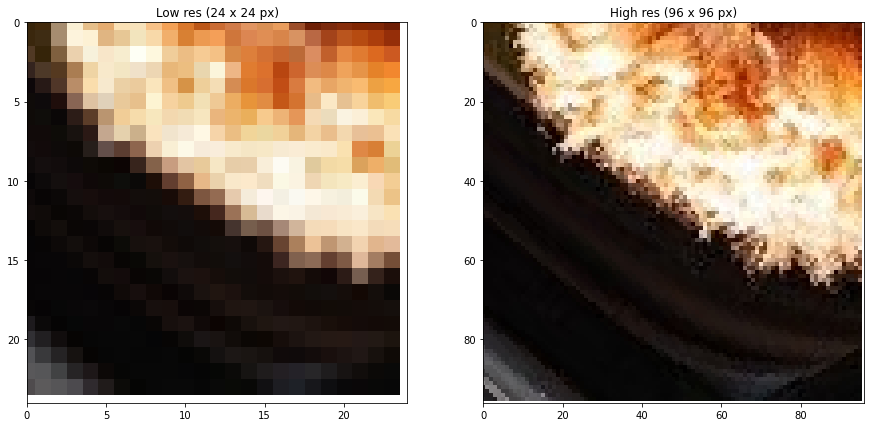

In [3]:
# The Dataset constructor has a transform attribute, we will cover it below. Just use this for now:
high_res_size = 96
low_res_size = 24

example_dataset = DataHandler("./dataset/", high_res_size ,low_res_size);
fig, axis = plt.subplots(1,2, figsize=(15,15))
some_random_index = 3
high_res_image_tensor, low_res_image_tensor = example_dataset[some_random_index]
display_image(axis[0], low_res_image_tensor)
axis[0].set_title('Low res (' + str(low_res_size) + ' x ' + str(low_res_size) + ' px)')
display_image(axis[1], high_res_image_tensor, reverse_normalization = True)
axis[1].set_title('High res (' + str(high_res_size) + ' x ' + str(high_res_size) + ' px)')

In [4]:
# Initialize models (with ModelHandler)
model_handler = ModelHandler()
generator, discriminator, disc_opti, gen_opti, gen_opti_pretrain, config_dict = model_handler.load_models()

# Initialize data
datahandler = DataHandler("./dataset/", config_dict['HIGH_RES_SIZE'] ,config_dict['LOW_RES_SIZE']);
train_dataloader = DataLoader(datahandler, batch_size=config_dict['BATCH_SIZE'], shuffle=True)

Load procedure initialized..
Enter stem of path (leave empty for new models): 
Loading models from scratch
high_res_size:           96
low_res_size:            24
scaling_factor:          2
batch_size:              32
num_epochs_train:        300
num_epochs_pretrain:     50
gen_lr:                  0.0001
gen_lr_pretrain:         0.001
disc_lr:                 0.0001
use_inception_blocks:    True
pixel_weight:            0.1
content_weight:          1
adversarial_weight:      0.005


In [5]:
# TRAINING TIME!
# Generator training (Pretraining)
generator, discriminator, disc_opti, gen_opti, gen_opti_pretrain, config_dict = train_loop(train_dataloader, generator, discriminator,  disc_opti, gen_opti, gen_opti_pretrain, config_dict, adversarial=False)

# Adversarial training (Regular Training)
generator, discriminator, disc_opti, gen_opti, gen_opti_pretrain, config_dict = train_loop(train_dataloader, generator, discriminator,  disc_opti, gen_opti, gen_opti_pretrain, config_dict, adversarial=True)

##################
Starting GENERATOR training
##################


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/50][100/157]	Loss_G: 0.0585


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2/50][100/157]	Loss_G: 0.0429


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3/50][100/157]	Loss_G: 0.0363


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[4/50][100/157]	Loss_G: 0.0453


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[5/50][100/157]	Loss_G: 0.0430


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[6/50][100/157]	Loss_G: 0.0386


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[7/50][100/157]	Loss_G: 0.0395


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[8/50][100/157]	Loss_G: 0.0422


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[9/50][100/157]	Loss_G: 0.0381


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[10/50][100/157]	Loss_G: 0.0308


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[11/50][100/157]	Loss_G: 0.0350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12/50][100/157]	Loss_G: 0.0340


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[13/50][100/157]	Loss_G: 0.0335


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[14/50][100/157]	Loss_G: 0.0318


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[15/50][100/157]	Loss_G: 0.0417


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[16/50][100/157]	Loss_G: 0.0348


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[17/50][100/157]	Loss_G: 0.0329


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[18/50][100/157]	Loss_G: 0.0351


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[19/50][100/157]	Loss_G: 0.0400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[20/50][100/157]	Loss_G: 0.0284


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[21/50][100/157]	Loss_G: 0.0344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[22/50][100/157]	Loss_G: 0.0333


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[23/50][100/157]	Loss_G: 0.0269


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[24/50][100/157]	Loss_G: 0.0366


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25/50][100/157]	Loss_G: 0.0328


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[26/50][100/157]	Loss_G: 0.0359


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[27/50][100/157]	Loss_G: 0.0289


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[28/50][100/157]	Loss_G: 0.0285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[29/50][100/157]	Loss_G: 0.0410


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[30/50][100/157]	Loss_G: 0.0467


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[31/50][100/157]	Loss_G: 0.0263


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[32/50][100/157]	Loss_G: 0.0391


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[33/50][100/157]	Loss_G: 0.0325


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[34/50][100/157]	Loss_G: 0.0359


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[35/50][100/157]	Loss_G: 0.0333


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[36/50][100/157]	Loss_G: 0.0330


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[37/50][100/157]	Loss_G: 0.0363


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[38/50][100/157]	Loss_G: 0.0274


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[39/50][100/157]	Loss_G: 0.0300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[40/50][100/157]	Loss_G: 0.0258


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[41/50][100/157]	Loss_G: 0.0277


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[42/50][100/157]	Loss_G: 0.0367


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[43/50][100/157]	Loss_G: 0.0294


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[44/50][100/157]	Loss_G: 0.0281


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[45/50][100/157]	Loss_G: 0.0354


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[46/50][100/157]	Loss_G: 0.0317


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[47/50][100/157]	Loss_G: 0.0346


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[48/50][100/157]	Loss_G: 0.0322


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[49/50][100/157]	Loss_G: 0.0296


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[50/50][100/157]	Loss_G: 0.0418
##################
Starting ADVERSARIAL training
##################


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/300][100/157]	Loss_D: 0.0007	Loss_G: 1.6800	D(x): 6.7460	D(G(z)): -3.1310 / -4.2520


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2/300][100/157]	Loss_D: 0.0001	Loss_G: 1.5338	D(x): 6.4291	D(G(z)): -6.4658 / -6.3942
[Memory increase alert] If this is a reoccuring print statement. Program might be subject to memory leak!
Current memory is: 491452928


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3/300][100/157]	Loss_D: 0.0001	Loss_G: 1.4857	D(x): 6.1652	D(G(z)): -7.0240 / -7.0229


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[4/300][100/157]	Loss_D: 0.0603	Loss_G: 1.5840	D(x): 0.5055	D(G(z)): -8.4619 / -8.0104


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[5/300][100/157]	Loss_D: 0.0006	Loss_G: 1.6346	D(x): 3.7241	D(G(z)): -7.9856 / -7.9847


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[6/300][100/157]	Loss_D: 0.0000	Loss_G: 1.6032	D(x): 7.9720	D(G(z)): -7.4712 / -7.4863


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[7/300][100/157]	Loss_D: 0.2797	Loss_G: 1.5925	D(x): -0.7669	D(G(z)): -11.7024 / -11.1624


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[8/300][100/157]	Loss_D: 0.0001	Loss_G: 1.4696	D(x): 2.7076	D(G(z)): -11.0285 / -11.0194


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[9/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4400	D(x): 10.4526	D(G(z)): -5.9111 / -5.8958


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[10/300][100/157]	Loss_D: 0.0001	Loss_G: 1.5273	D(x): 2.2020	D(G(z)): -10.8045 / -10.9264


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[11/300][100/157]	Loss_D: 0.3146	Loss_G: 1.3361	D(x): 3.4424	D(G(z)): -3.6931 / -4.4973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12/300][100/157]	Loss_D: 0.2492	Loss_G: 1.5657	D(x): 7.3079	D(G(z)): -2.4889 / -5.2791


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[13/300][100/157]	Loss_D: 0.0357	Loss_G: 1.3390	D(x): 5.5484	D(G(z)): -2.8539 / -3.7656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[14/300][100/157]	Loss_D: 0.0036	Loss_G: 1.4475	D(x): 4.5310	D(G(z)): -5.0758 / -6.2285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[15/300][100/157]	Loss_D: 0.0044	Loss_G: 1.5288	D(x): 2.0467	D(G(z)): -14.5759 / -14.8214


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[16/300][100/157]	Loss_D: 0.1451	Loss_G: 1.6329	D(x): 8.4634	D(G(z)): 4.0469 / 3.1716


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[17/300][100/157]	Loss_D: 0.0033	Loss_G: 1.5749	D(x): 5.4352	D(G(z)): -2.0003 / -2.2513


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[18/300][100/157]	Loss_D: 0.0006	Loss_G: 1.3529	D(x): -0.4584	D(G(z)): -13.0731 / -13.4759


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[19/300][100/157]	Loss_D: 0.0034	Loss_G: 1.4185	D(x): 13.5250	D(G(z)): 2.6555 / 7.2655


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[20/300][100/157]	Loss_D: 0.0001	Loss_G: 1.4121	D(x): -0.1041	D(G(z)): -13.2717 / -12.6449


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[21/300][100/157]	Loss_D: 0.0567	Loss_G: 1.4920	D(x): 5.4062	D(G(z)): -1.0920 / -1.6331


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[22/300][100/157]	Loss_D: 0.0051	Loss_G: 1.5758	D(x): 8.6034	D(G(z)): 0.7112 / 0.6347


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[23/300][100/157]	Loss_D: 0.0619	Loss_G: 1.2301	D(x): 11.4413	D(G(z)): 5.4791 / 10.6670


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[24/300][100/157]	Loss_D: 0.0335	Loss_G: 1.4838	D(x): 10.5655	D(G(z)): 3.2521 / 7.7145


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25/300][100/157]	Loss_D: 0.0041	Loss_G: 1.3927	D(x): -1.4405	D(G(z)): -9.7519 / -18.3227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[26/300][100/157]	Loss_D: 0.0002	Loss_G: 1.4149	D(x): 6.2520	D(G(z)): -6.5317 / -7.2591


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[27/300][100/157]	Loss_D: 0.0512	Loss_G: 1.4203	D(x): 7.7111	D(G(z)): 0.7407 / 0.3079


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[28/300][100/157]	Loss_D: 0.0718	Loss_G: 1.4202	D(x): 14.9232	D(G(z)): 9.4714 / 2.9424


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[29/300][100/157]	Loss_D: 0.2081	Loss_G: 1.5514	D(x): -1.2053	D(G(z)): -8.6932 / -7.6927


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[30/300][100/157]	Loss_D: 0.1293	Loss_G: 1.5379	D(x): 0.1475	D(G(z)): -4.6559 / -3.0328


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[31/300][100/157]	Loss_D: 0.0150	Loss_G: 1.4785	D(x): -1.9930	D(G(z)): -9.2234 / -5.6198


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[32/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5254	D(x): 5.2281	D(G(z)): -7.1901 / -10.8565


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[33/300][100/157]	Loss_D: 0.0943	Loss_G: 1.2461	D(x): 9.3519	D(G(z)): 2.7842 / -0.2558


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[34/300][100/157]	Loss_D: 0.0025	Loss_G: 1.3806	D(x): 10.8992	D(G(z)): 3.4037 / 3.3513


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[35/300][100/157]	Loss_D: 0.0529	Loss_G: 1.4529	D(x): 10.9071	D(G(z)): 2.7192 / -0.9724


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[36/300][100/157]	Loss_D: 0.0145	Loss_G: 1.3460	D(x): 7.6047	D(G(z)): 1.1216 / 1.4412


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[37/300][100/157]	Loss_D: 0.0158	Loss_G: 1.5655	D(x): 3.8018	D(G(z)): -2.7825 / -1.6036


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[38/300][100/157]	Loss_D: 0.0439	Loss_G: 1.3569	D(x): 0.7505	D(G(z)): -6.2980 / -8.7000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[39/300][100/157]	Loss_D: 0.0209	Loss_G: 1.4304	D(x): 9.1733	D(G(z)): 2.8747 / 0.6793


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[40/300][100/157]	Loss_D: 0.0024	Loss_G: 1.4435	D(x): 7.5075	D(G(z)): -1.4552 / 2.2004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[41/300][100/157]	Loss_D: 0.0001	Loss_G: 1.4375	D(x): 16.3389	D(G(z)): 4.0948 / 1.9807


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[42/300][100/157]	Loss_D: 0.0002	Loss_G: 1.5613	D(x): 9.3268	D(G(z)): -0.8252 / 1.3232


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[43/300][100/157]	Loss_D: 0.3742	Loss_G: 1.3489	D(x): 12.8719	D(G(z)): 9.0257 / -7.0592


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[44/300][100/157]	Loss_D: 0.2716	Loss_G: 1.5772	D(x): 1.1398	D(G(z)): -12.0604 / -2.6797


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[45/300][100/157]	Loss_D: 0.0204	Loss_G: 1.5223	D(x): 6.3192	D(G(z)): -4.5112 / -4.4123


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[46/300][100/157]	Loss_D: 0.4436	Loss_G: 1.3572	D(x): 21.4106	D(G(z)): 16.8297 / 16.9848


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[47/300][100/157]	Loss_D: 0.0018	Loss_G: 1.6049	D(x): 16.2721	D(G(z)): -0.7664 / -2.2945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[48/300][100/157]	Loss_D: 0.0062	Loss_G: 1.4380	D(x): 19.8083	D(G(z)): 11.4273 / 7.9797


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[49/300][100/157]	Loss_D: 2.6663	Loss_G: 1.6092	D(x): 30.9685	D(G(z)): 27.5262 / 6.7347


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[50/300][100/157]	Loss_D: 0.0161	Loss_G: 1.1976	D(x): 3.9907	D(G(z)): -2.8382 / 0.2350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[51/300][100/157]	Loss_D: 0.5313	Loss_G: 1.4173	D(x): 7.0311	D(G(z)): 5.2742 / 1.7409


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[52/300][100/157]	Loss_D: 0.0003	Loss_G: 1.5531	D(x): -6.2358	D(G(z)): -18.2943 / -16.1642


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[53/300][100/157]	Loss_D: 0.0005	Loss_G: 1.3905	D(x): 5.1492	D(G(z)): -4.8704 / -4.7019


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[54/300][100/157]	Loss_D: 0.0195	Loss_G: 1.4539	D(x): 2.9789	D(G(z)): -4.0340 / -1.8934


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[55/300][100/157]	Loss_D: 0.0393	Loss_G: 1.1564	D(x): 19.6599	D(G(z)): 11.1397 / 9.7039


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[56/300][100/157]	Loss_D: 0.0041	Loss_G: 1.4562	D(x): -13.6757	D(G(z)): -22.0625 / -23.2802


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[57/300][100/157]	Loss_D: 0.0036	Loss_G: 1.6050	D(x): -4.6405	D(G(z)): -13.1432 / -13.0444


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[58/300][100/157]	Loss_D: 0.0031	Loss_G: 1.3450	D(x): 17.3857	D(G(z)): 7.9724 / 5.3967


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[59/300][100/157]	Loss_D: 0.0016	Loss_G: 1.4266	D(x): 1.1742	D(G(z)): -7.4328 / -6.8862


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[60/300][100/157]	Loss_D: 0.0014	Loss_G: 1.5913	D(x): 9.1942	D(G(z)): -1.9671 / -1.9026


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[61/300][100/157]	Loss_D: 0.0160	Loss_G: 1.4304	D(x): 3.5155	D(G(z)): -3.8932 / -2.3356


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[62/300][100/157]	Loss_D: 0.0001	Loss_G: 1.5105	D(x): 9.1448	D(G(z)): -3.0371 / 1.2217


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[63/300][100/157]	Loss_D: 0.0352	Loss_G: 1.2677	D(x): 17.1460	D(G(z)): 9.1926 / 14.4456


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[64/300][100/157]	Loss_D: 0.0309	Loss_G: 1.2815	D(x): 2.6591	D(G(z)): -7.7865 / -7.1999


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[65/300][100/157]	Loss_D: 0.0003	Loss_G: 1.5801	D(x): 0.8754	D(G(z)): -9.8827 / -10.7319


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[66/300][100/157]	Loss_D: 0.0016	Loss_G: 1.2702	D(x): 8.3279	D(G(z)): -2.6425 / -3.9808


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[67/300][100/157]	Loss_D: 0.1263	Loss_G: 1.5974	D(x): 32.0749	D(G(z)): 23.9784 / 18.1929


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[68/300][100/157]	Loss_D: 0.0948	Loss_G: 1.3098	D(x): -9.5348	D(G(z)): -13.9962 / -9.4719


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[69/300][100/157]	Loss_D: 0.4672	Loss_G: 1.3056	D(x): 18.3609	D(G(z)): 13.3083 / 9.1316


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[70/300][100/157]	Loss_D: 0.0035	Loss_G: 1.4666	D(x): -3.8522	D(G(z)): -11.9442 / -15.6459


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[71/300][100/157]	Loss_D: 0.1071	Loss_G: 1.4005	D(x): -4.7927	D(G(z)): -11.4381 / -10.3154


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[72/300][100/157]	Loss_D: 0.0008	Loss_G: 1.6081	D(x): 11.7607	D(G(z)): 0.9612 / 3.0495


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[73/300][100/157]	Loss_D: 0.0015	Loss_G: 1.4730	D(x): 25.3934	D(G(z)): 11.7638 / 15.1787


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[74/300][100/157]	Loss_D: 0.0000	Loss_G: 1.6169	D(x): 13.0708	D(G(z)): -5.6443 / -7.0632


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[75/300][100/157]	Loss_D: 0.0133	Loss_G: 1.4324	D(x): -3.8074	D(G(z)): -10.7319 / -11.3745


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[76/300][100/157]	Loss_D: 3.0178	Loss_G: 1.5693	D(x): 3.0225	D(G(z)): 3.6315 / 0.0130


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[77/300][100/157]	Loss_D: 0.0021	Loss_G: 1.4532	D(x): 6.3953	D(G(z)): -2.5635 / -4.3745


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[78/300][100/157]	Loss_D: 0.0721	Loss_G: 1.3655	D(x): -8.1282	D(G(z)): -16.3413 / -12.9352


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[79/300][100/157]	Loss_D: 0.0009	Loss_G: 1.2524	D(x): 7.8490	D(G(z)): -3.2111 / -3.7029


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[80/300][100/157]	Loss_D: 0.0063	Loss_G: 1.3654	D(x): 10.1285	D(G(z)): 1.7003 / -4.3889


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[81/300][100/157]	Loss_D: 0.0006	Loss_G: 1.4054	D(x): -3.1578	D(G(z)): -12.7064 / -14.4642


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[82/300][100/157]	Loss_D: 0.0103	Loss_G: 1.5150	D(x): 21.0265	D(G(z)): 12.5527 / 10.7461


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[83/300][100/157]	Loss_D: 0.0695	Loss_G: 1.5225	D(x): 0.6182	D(G(z)): -8.2556 / -9.3128


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[84/300][100/157]	Loss_D: 0.4327	Loss_G: 1.5297	D(x): -5.5212	D(G(z)): -9.7934 / -2.5163


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[85/300][100/157]	Loss_D: 0.0001	Loss_G: 1.5874	D(x): 9.6604	D(G(z)): -3.6998 / -4.1149


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[86/300][100/157]	Loss_D: 0.0008	Loss_G: 1.5569	D(x): 15.1044	D(G(z)): 5.7454 / 8.5965


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[87/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4418	D(x): 6.9514	D(G(z)): -8.6570 / 4.5951


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[88/300][100/157]	Loss_D: 0.1994	Loss_G: 1.5285	D(x): -10.4721	D(G(z)): -15.1096 / -16.4615


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[89/300][100/157]	Loss_D: 0.0328	Loss_G: 1.3157	D(x): 0.2819	D(G(z)): -5.0746 / -5.4481


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[90/300][100/157]	Loss_D: 0.0012	Loss_G: 1.5330	D(x): 1.1192	D(G(z)): -10.9132 / -14.7123


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[91/300][100/157]	Loss_D: 0.0316	Loss_G: 1.4874	D(x): -1.8019	D(G(z)): -8.7672 / -9.8830


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[92/300][100/157]	Loss_D: 0.0137	Loss_G: 1.3974	D(x): -5.1356	D(G(z)): -12.4938 / -22.5572


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[93/300][100/157]	Loss_D: 0.0050	Loss_G: 1.4740	D(x): -8.9723	D(G(z)): -20.2723 / -26.7820


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[94/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4093	D(x): 13.9896	D(G(z)): -0.9584 / -11.2981


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[95/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5920	D(x): 30.3351	D(G(z)): 16.3157 / 13.4878


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[96/300][100/157]	Loss_D: 0.0000	Loss_G: 1.3675	D(x): 6.2197	D(G(z)): -8.3094 / -16.6352


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[97/300][100/157]	Loss_D: 0.7227	Loss_G: 1.1781	D(x): 0.9854	D(G(z)): -0.5236 / -9.6713


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[98/300][100/157]	Loss_D: 0.0759	Loss_G: 1.3605	D(x): 3.4786	D(G(z)): -4.1415 / -4.2746


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[99/300][100/157]	Loss_D: 0.0120	Loss_G: 1.3837	D(x): -4.0108	D(G(z)): -11.0945 / -13.3120


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[100/300][100/157]	Loss_D: 0.0008	Loss_G: 1.5447	D(x): -14.5098	D(G(z)): -25.7155 / -24.4174


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[101/300][100/157]	Loss_D: 0.0083	Loss_G: 1.4995	D(x): -15.7007	D(G(z)): -22.6855 / -24.8234


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[102/300][100/157]	Loss_D: 0.0292	Loss_G: 1.4720	D(x): -8.3499	D(G(z)): -20.1037 / -22.3626


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[103/300][100/157]	Loss_D: 0.0001	Loss_G: 1.5720	D(x): 4.8369	D(G(z)): -6.1213 / -6.6251


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[104/300][100/157]	Loss_D: 0.0001	Loss_G: 1.5667	D(x): -7.0000	D(G(z)): -18.8693 / -22.5880


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[105/300][100/157]	Loss_D: 0.0257	Loss_G: 1.4395	D(x): 5.5038	D(G(z)): -1.5801 / -0.8181


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[106/300][100/157]	Loss_D: 0.0127	Loss_G: 1.3409	D(x): -12.2715	D(G(z)): -20.2974 / -18.0934


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[107/300][100/157]	Loss_D: 0.2699	Loss_G: 1.5067	D(x): 12.8064	D(G(z)): 6.4044 / 5.6794


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[108/300][100/157]	Loss_D: 0.0058	Loss_G: 1.4183	D(x): 6.6074	D(G(z)): -0.1842 / 0.2153


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[109/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5597	D(x): 7.0538	D(G(z)): -10.4694 / -10.7238


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[110/300][100/157]	Loss_D: 0.0007	Loss_G: 1.3945	D(x): 25.8053	D(G(z)): 12.8348 / 13.4707


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[111/300][100/157]	Loss_D: 0.0000	Loss_G: 1.6825	D(x): 28.4211	D(G(z)): 12.2136 / 11.0515


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[112/300][100/157]	Loss_D: 0.0006	Loss_G: 1.2897	D(x): -0.8640	D(G(z)): -12.2802 / -11.6336


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[113/300][100/157]	Loss_D: 0.0133	Loss_G: 1.3749	D(x): 38.4753	D(G(z)): 30.6954 / 33.3015


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[114/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5806	D(x): 11.4204	D(G(z)): -2.1316 / 2.2886


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[115/300][100/157]	Loss_D: 0.0000	Loss_G: 1.6609	D(x): 26.8664	D(G(z)): 1.8502 / 0.2015


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[116/300][100/157]	Loss_D: 0.2274	Loss_G: 1.6226	D(x): 5.4080	D(G(z)): 2.6918 / 2.2914


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[117/300][100/157]	Loss_D: 0.0001	Loss_G: 1.5620	D(x): -0.3981	D(G(z)): -16.0189 / -16.1467


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[118/300][100/157]	Loss_D: 0.0010	Loss_G: 1.6295	D(x): 5.5079	D(G(z)): -4.7860 / -4.3245


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[119/300][100/157]	Loss_D: 1.2348	Loss_G: 1.2538	D(x): -33.6530	D(G(z)): -36.7690 / -32.8958


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[120/300][100/157]	Loss_D: 0.0028	Loss_G: 1.4628	D(x): 6.3042	D(G(z)): -1.2289 / -1.7386


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[121/300][100/157]	Loss_D: 0.0258	Loss_G: 1.4476	D(x): 2.6062	D(G(z)): -2.3233 / -2.5779


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[122/300][100/157]	Loss_D: 0.0062	Loss_G: 1.4709	D(x): 5.1503	D(G(z)): -3.4742 / -3.4276


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[123/300][100/157]	Loss_D: 0.0027	Loss_G: 1.5580	D(x): 15.2099	D(G(z)): 0.6650 / -1.4644


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[124/300][100/157]	Loss_D: 0.0167	Loss_G: 1.4475	D(x): 16.6860	D(G(z)): 8.3470 / 5.5450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[125/300][100/157]	Loss_D: 0.0004	Loss_G: 1.6234	D(x): 2.5398	D(G(z)): -10.6611 / -14.4439


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[126/300][100/157]	Loss_D: 0.0014	Loss_G: 1.5858	D(x): 2.0363	D(G(z)): -6.6036 / -7.2090


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[127/300][100/157]	Loss_D: 0.1368	Loss_G: 1.5874	D(x): -15.3620	D(G(z)): -27.3429 / -24.8766


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[128/300][100/157]	Loss_D: 0.0542	Loss_G: 1.5311	D(x): -1.9127	D(G(z)): -9.6560 / -5.0107


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[129/300][100/157]	Loss_D: 0.0303	Loss_G: 1.5584	D(x): 17.3238	D(G(z)): 12.1210 / 3.6816


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[130/300][100/157]	Loss_D: 0.1510	Loss_G: 1.5900	D(x): 10.0422	D(G(z)): 6.1500 / 7.0193


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[131/300][100/157]	Loss_D: 0.0324	Loss_G: 1.4436	D(x): 1.1762	D(G(z)): -7.6775 / -6.3580


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[132/300][100/157]	Loss_D: 0.0106	Loss_G: 1.3860	D(x): -0.5453	D(G(z)): -14.3820 / -12.3334


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[133/300][100/157]	Loss_D: 0.0589	Loss_G: 1.2906	D(x): 13.2976	D(G(z)): 7.5118 / 7.9376


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[134/300][100/157]	Loss_D: 0.5005	Loss_G: 1.2253	D(x): 5.6585	D(G(z)): 1.9037 / 1.7749


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[135/300][100/157]	Loss_D: 0.0002	Loss_G: 1.3408	D(x): -8.0707	D(G(z)): -19.7901 / -19.9225


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[136/300][100/157]	Loss_D: 0.0167	Loss_G: 1.4682	D(x): 1.7064	D(G(z)): -9.2820 / -10.1029


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[137/300][100/157]	Loss_D: 0.0078	Loss_G: 1.4747	D(x): 17.0983	D(G(z)): 2.9804 / 1.3224


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[138/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4752	D(x): 28.3596	D(G(z)): 10.3611 / 10.4818


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[139/300][100/157]	Loss_D: 0.2078	Loss_G: 1.3113	D(x): -24.5368	D(G(z)): -33.7250 / -35.8825


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[140/300][100/157]	Loss_D: 0.0008	Loss_G: 1.5125	D(x): 17.9086	D(G(z)): 8.4493 / 8.4486


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[141/300][100/157]	Loss_D: 0.0001	Loss_G: 1.4070	D(x): -12.7227	D(G(z)): -24.3311 / -24.3290


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[142/300][100/157]	Loss_D: 0.1542	Loss_G: 1.5601	D(x): -13.7030	D(G(z)): -25.2601 / -22.1554


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[143/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5111	D(x): 27.3169	D(G(z)): 6.6714 / 7.9063


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[144/300][100/157]	Loss_D: 0.0001	Loss_G: 1.3518	D(x): 21.9000	D(G(z)): 8.1857 / 8.8083


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[145/300][100/157]	Loss_D: 0.0279	Loss_G: 1.3935	D(x): -9.9089	D(G(z)): -19.1626 / -17.3921


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[146/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4386	D(x): -6.5711	D(G(z)): -21.6288 / -21.2737


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[147/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4466	D(x): -21.7141	D(G(z)): -34.2901 / -32.7406


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[148/300][100/157]	Loss_D: 0.0058	Loss_G: 1.4608	D(x): 9.4314	D(G(z)): -2.6730 / -3.0779


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[149/300][100/157]	Loss_D: 0.0041	Loss_G: 1.3357	D(x): 31.1992	D(G(z)): 22.5198 / 22.0512


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[150/300][100/157]	Loss_D: 0.0021	Loss_G: 1.3710	D(x): -6.7212	D(G(z)): -15.5254 / -15.1299


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[151/300][100/157]	Loss_D: 0.0001	Loss_G: 1.3962	D(x): -5.3045	D(G(z)): -17.9960 / -18.1596


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[152/300][100/157]	Loss_D: 0.0195	Loss_G: 1.3451	D(x): -6.7666	D(G(z)): -13.8742 / -13.9979


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[153/300][100/157]	Loss_D: 0.0000	Loss_G: 1.3588	D(x): 12.6249	D(G(z)): -16.1933 / -8.8711


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[154/300][100/157]	Loss_D: 0.0000	Loss_G: 1.2737	D(x): 11.5738	D(G(z)): -5.6330 / -5.3963


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[155/300][100/157]	Loss_D: 0.0246	Loss_G: 1.4992	D(x): -5.6996	D(G(z)): -17.3879 / -16.2434


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[156/300][100/157]	Loss_D: 0.0160	Loss_G: 1.4153	D(x): 13.2405	D(G(z)): 3.9204 / -3.0580


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[157/300][100/157]	Loss_D: 0.0183	Loss_G: 1.2962	D(x): 26.9174	D(G(z)): 19.6288 / 19.4985


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[158/300][100/157]	Loss_D: 0.0981	Loss_G: 1.4140	D(x): 19.5486	D(G(z)): 15.3246 / 15.2103


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[159/300][100/157]	Loss_D: 0.0320	Loss_G: 1.4617	D(x): 8.4620	D(G(z)): 2.5031 / 5.8469


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[160/300][100/157]	Loss_D: 0.0000	Loss_G: 1.3408	D(x): 13.0916	D(G(z)): 1.1347 / 0.1202


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[161/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4630	D(x): 13.1892	D(G(z)): -5.5012 / -5.5847


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[162/300][100/157]	Loss_D: 0.0015	Loss_G: 1.2774	D(x): -13.8871	D(G(z)): -23.3201 / -22.0158


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[163/300][100/157]	Loss_D: 0.0030	Loss_G: 1.2540	D(x): 24.5121	D(G(z)): 15.9310 / 15.9586


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[164/300][100/157]	Loss_D: 0.0000	Loss_G: 1.6070	D(x): 27.6382	D(G(z)): 7.4481 / 8.8464


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[165/300][100/157]	Loss_D: 0.0000	Loss_G: 1.3384	D(x): 25.2396	D(G(z)): 6.6411 / 6.5949


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[166/300][100/157]	Loss_D: 0.0027	Loss_G: 1.3684	D(x): 11.3580	D(G(z)): 1.7128 / 0.4330


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[167/300][100/157]	Loss_D: 0.0445	Loss_G: 1.4202	D(x): -2.7128	D(G(z)): -12.2324 / -12.6480


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[168/300][100/157]	Loss_D: 0.0201	Loss_G: 1.5788	D(x): 24.6514	D(G(z)): 14.5791 / 14.6557


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[169/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4112	D(x): 15.9577	D(G(z)): -0.8225 / -0.3678


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[170/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4723	D(x): 17.8475	D(G(z)): -2.6447 / 0.4804


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[171/300][100/157]	Loss_D: 0.0000	Loss_G: 1.3496	D(x): 28.1139	D(G(z)): 6.5927 / -3.9081


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[172/300][100/157]	Loss_D: 0.0061	Loss_G: 1.3203	D(x): -5.7771	D(G(z)): -12.8160 / -10.5470


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[173/300][100/157]	Loss_D: 0.0020	Loss_G: 1.5008	D(x): 2.6301	D(G(z)): -7.1326 / -7.1171


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[174/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5264	D(x): 14.1434	D(G(z)): -5.0343 / -4.6359


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[175/300][100/157]	Loss_D: 0.0096	Loss_G: 1.4443	D(x): 31.9587	D(G(z)): 17.0835 / 16.1122


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[176/300][100/157]	Loss_D: 0.0484	Loss_G: 1.4175	D(x): -4.3681	D(G(z)): -10.4001 / -8.5119


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[177/300][100/157]	Loss_D: 0.0035	Loss_G: 1.4112	D(x): 21.2935	D(G(z)): 13.1578 / 13.1254


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[178/300][100/157]	Loss_D: 0.0019	Loss_G: 1.3803	D(x): 17.0493	D(G(z)): 9.6640 / 10.0236


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[179/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4999	D(x): 32.3010	D(G(z)): 17.6394 / 18.2211


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[180/300][100/157]	Loss_D: 0.0005	Loss_G: 1.3982	D(x): 11.5354	D(G(z)): 0.1941 / 0.1965


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[181/300][100/157]	Loss_D: 0.0000	Loss_G: 1.6968	D(x): -0.3469	D(G(z)): -16.9538 / -16.9769


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[182/300][100/157]	Loss_D: 0.0051	Loss_G: 1.3596	D(x): 39.3788	D(G(z)): 27.2520 / 26.5440


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[183/300][100/157]	Loss_D: 0.0073	Loss_G: 1.5063	D(x): 9.7397	D(G(z)): 1.3821 / 0.8801


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[184/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5643	D(x): 10.7143	D(G(z)): -1.9137 / -1.8732


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[185/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5616	D(x): 25.8841	D(G(z)): -2.1830 / -2.3163


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[186/300][100/157]	Loss_D: 0.0000	Loss_G: 1.3042	D(x): 22.1848	D(G(z)): 1.1868 / 1.6204


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[187/300][100/157]	Loss_D: 0.0014	Loss_G: 1.2717	D(x): 4.9182	D(G(z)): -3.5917 / -3.4207


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[188/300][100/157]	Loss_D: 0.0000	Loss_G: 1.3640	D(x): -7.1101	D(G(z)): -20.9419 / -21.5944


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[189/300][100/157]	Loss_D: 0.1447	Loss_G: 1.4549	D(x): 10.7387	D(G(z)): 7.1858 / 7.5170


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[190/300][100/157]	Loss_D: 0.0001	Loss_G: 1.5725	D(x): 11.4392	D(G(z)): 0.6204 / 1.1165


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[191/300][100/157]	Loss_D: 0.0008	Loss_G: 1.5098	D(x): 13.4840	D(G(z)): 2.7728 / -0.7706


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[192/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5815	D(x): 31.4875	D(G(z)): 6.3317 / 0.7259


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[193/300][100/157]	Loss_D: 0.0018	Loss_G: 1.3474	D(x): -3.2568	D(G(z)): -12.1385 / -12.6789


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[194/300][100/157]	Loss_D: 0.0049	Loss_G: 1.3138	D(x): -1.5561	D(G(z)): -9.3664 / -9.0843


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[195/300][100/157]	Loss_D: 0.0028	Loss_G: 1.4446	D(x): 2.7824	D(G(z)): -4.2240 / -3.9605


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[196/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4481	D(x): 8.0866	D(G(z)): -3.5039 / -4.0600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[197/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4108	D(x): 12.5500	D(G(z)): -0.6702 / -0.7595


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[198/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5094	D(x): 12.1024	D(G(z)): -3.9000 / -3.9520


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[199/300][100/157]	Loss_D: 0.0022	Loss_G: 1.3290	D(x): 10.1894	D(G(z)): 2.6748 / 2.6255


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[200/300][100/157]	Loss_D: 0.0002	Loss_G: 1.5387	D(x): 15.4540	D(G(z)): 5.4734 / 5.3825


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[201/300][100/157]	Loss_D: 0.0916	Loss_G: 1.5064	D(x): 44.3104	D(G(z)): 30.2353 / 26.2239


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[202/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4880	D(x): 12.1726	D(G(z)): -7.2358 / -8.9622


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[203/300][100/157]	Loss_D: 0.0335	Loss_G: 1.3968	D(x): -13.1380	D(G(z)): -21.5492 / -20.6658


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[204/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4693	D(x): -5.1618	D(G(z)): -20.1330 / -20.4566


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[205/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4405	D(x): 25.2694	D(G(z)): -2.8608 / -2.5706


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[206/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4657	D(x): 38.8228	D(G(z)): 21.8302 / 19.3416


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[207/300][100/157]	Loss_D: 0.0018	Loss_G: 1.4829	D(x): 30.3533	D(G(z)): 19.4271 / 18.6024


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[208/300][100/157]	Loss_D: 0.0001	Loss_G: 1.3840	D(x): 2.0215	D(G(z)): -13.1487 / -13.9633


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[209/300][100/157]	Loss_D: 0.0007	Loss_G: 1.4680	D(x): 22.4512	D(G(z)): 11.6644 / 11.1819


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[210/300][100/157]	Loss_D: 0.0000	Loss_G: 1.9088	D(x): 32.8541	D(G(z)): 7.2631 / 7.4426


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[211/300][100/157]	Loss_D: 0.0001	Loss_G: 1.4191	D(x): 9.1560	D(G(z)): -7.8018 / -9.9934


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[212/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5044	D(x): 11.9252	D(G(z)): -6.7294 / -11.9480


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[213/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4564	D(x): -5.7435	D(G(z)): -17.9245 / -21.4957


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[214/300][100/157]	Loss_D: 0.0012	Loss_G: 1.3063	D(x): 24.4790	D(G(z)): 11.3534 / 12.6087


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[215/300][100/157]	Loss_D: 0.1434	Loss_G: 1.4846	D(x): 5.7687	D(G(z)): 2.4922 / -3.9400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[216/300][100/157]	Loss_D: 0.0000	Loss_G: 1.3323	D(x): -15.3871	D(G(z)): -34.4492 / -34.8993


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[217/300][100/157]	Loss_D: 0.0000	Loss_G: 1.3770	D(x): 11.0645	D(G(z)): -7.9891 / -7.9323


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[218/300][100/157]	Loss_D: 0.0044	Loss_G: 1.3317	D(x): -13.3506	D(G(z)): -33.8427 / -33.2767


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[219/300][100/157]	Loss_D: 0.0001	Loss_G: 1.5349	D(x): 0.6501	D(G(z)): -13.6443 / -13.9571


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[220/300][100/157]	Loss_D: 0.0053	Loss_G: 1.5466	D(x): 26.6888	D(G(z)): 15.9824 / 13.1663


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[221/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5566	D(x): -9.5253	D(G(z)): -26.2990 / -26.3769


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[222/300][100/157]	Loss_D: 0.0001	Loss_G: 1.3820	D(x): 30.0808	D(G(z)): 12.8679 / 12.8582


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[223/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5057	D(x): 24.4987	D(G(z)): 9.1146 / 9.4565


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[224/300][100/157]	Loss_D: 0.1614	Loss_G: 1.4836	D(x): 4.2172	D(G(z)): 0.0732 / -5.0489


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[225/300][100/157]	Loss_D: 0.0000	Loss_G: 1.2917	D(x): 33.0894	D(G(z)): 12.6469 / 13.7769


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[226/300][100/157]	Loss_D: 0.0000	Loss_G: 1.6233	D(x): 37.5476	D(G(z)): 22.7815 / 22.5199


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[227/300][100/157]	Loss_D: 0.0000	Loss_G: 1.3575	D(x): 18.4737	D(G(z)): -1.3376 / -1.1660


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[228/300][100/157]	Loss_D: 0.0392	Loss_G: 1.5376	D(x): 29.6252	D(G(z)): 11.3433 / 10.7526


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[229/300][100/157]	Loss_D: 0.0001	Loss_G: 1.4184	D(x): -3.0444	D(G(z)): -17.3513 / -17.9754


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[230/300][100/157]	Loss_D: 0.0000	Loss_G: 1.6150	D(x): 2.1542	D(G(z)): -15.3530 / -15.4319


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[231/300][100/157]	Loss_D: 0.0000	Loss_G: 1.6616	D(x): 5.3361	D(G(z)): -18.9519 / -21.7325


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[232/300][100/157]	Loss_D: 0.0001	Loss_G: 1.5079	D(x): -6.9560	D(G(z)): -19.2166 / -18.7555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[233/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4760	D(x): 3.1686	D(G(z)): -13.9852 / -15.7069


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[234/300][100/157]	Loss_D: 0.0001	Loss_G: 1.5312	D(x): -14.9441	D(G(z)): -28.9901 / -28.9617


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[235/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4250	D(x): 0.1468	D(G(z)): -14.5909 / -15.0542


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[236/300][100/157]	Loss_D: 0.0839	Loss_G: 1.4733	D(x): 8.6520	D(G(z)): 3.8483 / 1.6239


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[237/300][100/157]	Loss_D: 0.0029	Loss_G: 1.3883	D(x): 25.8188	D(G(z)): 14.2512 / 13.3581


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[238/300][100/157]	Loss_D: 0.1286	Loss_G: 1.2687	D(x): 11.1526	D(G(z)): 5.7517 / 7.8664


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[239/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4409	D(x): -0.3435	D(G(z)): -20.0128 / -19.8570


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[240/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5588	D(x): 36.8085	D(G(z)): 4.7133 / 4.0134


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[241/300][100/157]	Loss_D: 0.0001	Loss_G: 1.5104	D(x): 37.5089	D(G(z)): 23.9142 / 22.9629


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[242/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5710	D(x): 22.4801	D(G(z)): 2.5685 / 2.7723


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[243/300][100/157]	Loss_D: 0.0012	Loss_G: 1.4263	D(x): 20.9672	D(G(z)): 10.7668 / 5.5852


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[244/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4273	D(x): 3.6962	D(G(z)): -8.3119 / -8.0589


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[245/300][100/157]	Loss_D: 0.0001	Loss_G: 1.4797	D(x): 12.8461	D(G(z)): -6.2719 / -5.3450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[246/300][100/157]	Loss_D: 0.0002	Loss_G: 1.4219	D(x): 25.9026	D(G(z)): 14.7597 / 15.5951


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[247/300][100/157]	Loss_D: 0.8984	Loss_G: 1.2733	D(x): -11.6127	D(G(z)): -18.5612 / -11.0241


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[248/300][100/157]	Loss_D: 0.0027	Loss_G: 1.4196	D(x): 25.3282	D(G(z)): 15.8326 / 17.8381


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[249/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4577	D(x): 34.9556	D(G(z)): 3.4739 / 2.9224


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[250/300][100/157]	Loss_D: 0.0013	Loss_G: 1.3424	D(x): 14.7909	D(G(z)): -1.9814 / -1.9951


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[251/300][100/157]	Loss_D: 0.0003	Loss_G: 1.2837	D(x): -7.5701	D(G(z)): -17.8394 / -17.9611


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[252/300][100/157]	Loss_D: 0.0010	Loss_G: 1.4959	D(x): 31.2444	D(G(z)): 22.2403 / 22.2977


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[253/300][100/157]	Loss_D: 0.0256	Loss_G: 1.5304	D(x): -24.7121	D(G(z)): -32.5211 / -34.1419


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[254/300][100/157]	Loss_D: 0.0026	Loss_G: 1.2223	D(x): 52.5349	D(G(z)): 33.9823 / 38.3720


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[255/300][100/157]	Loss_D: 0.0000	Loss_G: 1.3428	D(x): 19.2564	D(G(z)): 5.3393 / 5.1377


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[256/300][100/157]	Loss_D: 0.0001	Loss_G: 1.4434	D(x): -2.3704	D(G(z)): -13.3442 / -14.4376


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[257/300][100/157]	Loss_D: 0.0000	Loss_G: 1.3280	D(x): 37.0603	D(G(z)): 7.0353 / 6.8474


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[258/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4358	D(x): 11.4841	D(G(z)): -4.2429 / 2.3057


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[259/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5037	D(x): 2.4282	D(G(z)): -10.8580 / -10.6850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[260/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5077	D(x): 5.6311	D(G(z)): -12.3628 / -17.1980


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[261/300][100/157]	Loss_D: 0.4479	Loss_G: 1.5611	D(x): -14.9217	D(G(z)): -27.6322 / -30.0870


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[262/300][100/157]	Loss_D: 0.0000	Loss_G: 1.6325	D(x): 17.8864	D(G(z)): 0.6879 / 0.5711


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[263/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4459	D(x): 17.5992	D(G(z)): 2.8613 / 2.1481


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[264/300][100/157]	Loss_D: 0.0002	Loss_G: 1.4682	D(x): 20.6691	D(G(z)): 3.3575 / 3.1833


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[265/300][100/157]	Loss_D: 0.1122	Loss_G: 1.3663	D(x): 18.6851	D(G(z)): 8.3757 / 9.4345


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[266/300][100/157]	Loss_D: 0.0383	Loss_G: 1.5443	D(x): 25.6737	D(G(z)): 9.5635 / 10.6214


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[267/300][100/157]	Loss_D: 0.0367	Loss_G: 1.3595	D(x): 0.0889	D(G(z)): -5.6394 / -4.3966


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[268/300][100/157]	Loss_D: 0.0000	Loss_G: 1.6864	D(x): 15.8101	D(G(z)): -0.4267 / -3.3766


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[269/300][100/157]	Loss_D: 0.0007	Loss_G: 1.3837	D(x): 28.9175	D(G(z)): 14.8134 / 14.2054


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[270/300][100/157]	Loss_D: 0.0001	Loss_G: 1.3779	D(x): 3.3045	D(G(z)): -8.8337 / -7.6556


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[271/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5374	D(x): 8.7954	D(G(z)): -6.4838 / -4.4226


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[272/300][100/157]	Loss_D: 0.0544	Loss_G: 1.4962	D(x): -4.9460	D(G(z)): -15.1509 / -16.7885


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[273/300][100/157]	Loss_D: 0.0001	Loss_G: 1.3139	D(x): 14.0636	D(G(z)): -1.8526 / -1.4495


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[274/300][100/157]	Loss_D: 0.6650	Loss_G: 1.2732	D(x): -17.5304	D(G(z)): -19.3815 / -21.3153


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[275/300][100/157]	Loss_D: 0.0098	Loss_G: 1.3417	D(x): 47.0586	D(G(z)): 37.8302 / 42.3218


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[276/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4822	D(x): 26.7643	D(G(z)): 3.4533 / 3.5441


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[277/300][100/157]	Loss_D: 0.0002	Loss_G: 1.4135	D(x): 0.2926	D(G(z)): -12.4352 / -12.2803


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[278/300][100/157]	Loss_D: 0.0001	Loss_G: 1.4107	D(x): -4.2336	D(G(z)): -17.0202 / -16.5853


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[279/300][100/157]	Loss_D: 0.0401	Loss_G: 1.4714	D(x): -13.7680	D(G(z)): -20.7529 / -20.5394


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[280/300][100/157]	Loss_D: 0.0249	Loss_G: 1.5186	D(x): -8.0636	D(G(z)): -19.3105 / -18.1172


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[281/300][100/157]	Loss_D: 0.0051	Loss_G: 1.4204	D(x): 14.8151	D(G(z)): 7.3718 / 8.1382


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[282/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5437	D(x): 18.9542	D(G(z)): 3.8402 / 3.6316


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[283/300][100/157]	Loss_D: 0.0046	Loss_G: 1.4008	D(x): 6.0877	D(G(z)): -3.1241 / -2.2313


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[284/300][100/157]	Loss_D: 0.0003	Loss_G: 1.3423	D(x): 6.2986	D(G(z)): -5.6310 / -4.6751


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[285/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5422	D(x): 15.5687	D(G(z)): -10.8079 / -7.6439


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[286/300][100/157]	Loss_D: 0.0000	Loss_G: 1.4289	D(x): 12.7134	D(G(z)): 0.1168 / 0.1514


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[287/300][100/157]	Loss_D: 0.0000	Loss_G: 1.6136	D(x): 30.4504	D(G(z)): 10.2548 / 6.2220


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[288/300][100/157]	Loss_D: 0.0042	Loss_G: 1.5069	D(x): 32.4667	D(G(z)): 20.9577 / 16.9591


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[289/300][100/157]	Loss_D: 0.0572	Loss_G: 1.4313	D(x): 13.1282	D(G(z)): 8.0615 / 4.1013


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[290/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5303	D(x): 12.9047	D(G(z)): -4.5526 / -4.0089


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[291/300][100/157]	Loss_D: 0.0003	Loss_G: 1.4983	D(x): 16.2938	D(G(z)): 5.6677 / 5.8023


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[292/300][100/157]	Loss_D: 0.0000	Loss_G: 1.6612	D(x): 17.3663	D(G(z)): 2.3325 / 3.1558


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[293/300][100/157]	Loss_D: 0.9412	Loss_G: 1.5471	D(x): -16.9072	D(G(z)): -20.2577 / -16.5820


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[294/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5425	D(x): 12.8175	D(G(z)): -5.9157 / -5.8095


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[295/300][100/157]	Loss_D: 0.0000	Loss_G: 1.2938	D(x): 12.7732	D(G(z)): -1.9953 / -1.6200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[296/300][100/157]	Loss_D: 0.0000	Loss_G: 1.3923	D(x): -6.9949	D(G(z)): -23.5229 / -25.2302


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[297/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5863	D(x): -9.8678	D(G(z)): -32.7691 / -30.0307


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[298/300][100/157]	Loss_D: 0.0001	Loss_G: 1.5644	D(x): 20.1453	D(G(z)): 7.3736 / 7.5485


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[299/300][100/157]	Loss_D: 0.0000	Loss_G: 1.5018	D(x): 14.2322	D(G(z)): -4.6814 / -4.5892


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[300/300][100/157]	Loss_D: 0.0071	Loss_G: 1.3038	D(x): 11.4936	D(G(z)): 5.2062 / 5.2616


In [6]:
# Save the model
folder_path = model_handler.save_models(generator, discriminator, disc_opti, gen_opti, gen_opti_pretrain, config_dict)

# Save result images
if folder_path:
    save_result_images(generator, datahandler, folder_path)

Saving procedure initialized..
Enter stem of path (leave empty if you don't want to save): inception-residual-block
Saved succesfully
Succesfully saved result images in ./saved-models/inception-residual-block


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


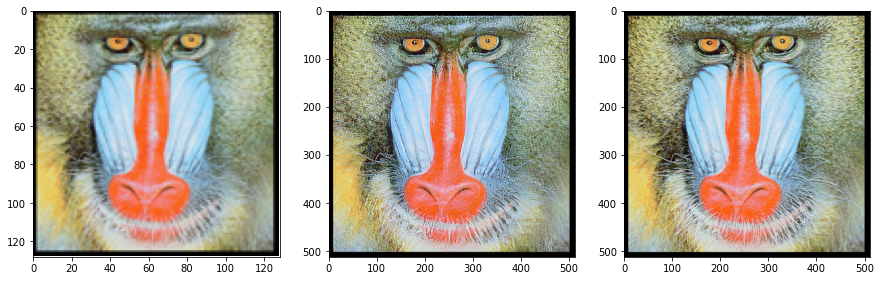

In [7]:
# placeholder code for displaying an image from generator
with torch.no_grad():
    img_lr = datahandler.get_sample_by_name('baboon', 128)
    img_hr = datahandler.get_sample_by_name('baboon', 512)
    fig, ax = plt.subplots(1, 3, figsize=(15,15))
    display_image(ax[0], img_lr)
    display_image(ax[1], generator.forward(torch.unsqueeze(img_lr.cuda().detach(), 0))[-1].cpu(), reverse_normalization=True)
    display_image(ax[2], img_hr)